# Predicting Vaccination Likelyhood

## Business Understanding

In light of their new vaccination initiative, the CDC has conducted surveys on random individuals throughout the country. Deliver a predictive binary classifier model to stakeholder (CDC) that determines if someone will take the Seasonal Flu vaccine based on responses to a phone survey. Predictions on future surveys can help assess public health risk by determining the percent of the population likely to get vaccinated.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import scipy.stats as stats
from sklearn.model_selection import train_test_split, cross_val_score,GridSearchCV
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from sklearn.metrics import confusion_matrix,plot_confusion_matrix, roc_auc_score, plot_roc_curve
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_selection import RFE
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

## Data Cleaning & Exploration

In [2]:
df_var = pd.read_csv('data/training_set_features.csv')
df_tar = pd.read_csv('data/training_set_labels.csv')['seasonal_vaccine']
df_var = df_var.drop(['respondent_id','h1n1_concern','h1n1_knowledge','opinion_h1n1_vacc_effective','opinion_h1n1_risk','opinion_h1n1_sick_from_vacc','doctor_recc_h1n1','hhs_geo_region'],axis=1)
df_var = df_var.drop(['health_insurance','income_poverty','employment_industry','employment_occupation'],axis=1)

X_train,X_test,y_train,y_test = train_test_split(df_var,df_tar,random_state=42)
X_train = X_train.copy(deep=True)

### Preprocessing

'doctor_recc_seasonal'

In [3]:
majority_columns = ['behavioral_antiviral_meds', 'behavioral_avoidance',
                     'behavioral_face_mask', 'behavioral_wash_hands',
                     'behavioral_large_gatherings', 'behavioral_outside_home',
                     'behavioral_touch_face', 'doctor_recc_seasonal',
                     'chronic_med_condition', 'child_under_6_months', 'health_worker',
                     'education', 'rent_or_own', 'marital_status', 'employment_status',
                     'sex'
                  ]
opinion_columns = ['opinion_seas_vacc_effective', 'opinion_seas_risk',
                   'opinion_seas_sick_from_vacc','household_adults', 'household_children'
                   ]
ohe_columns = ['opinion_seas_vacc_effective', 'opinion_seas_risk',
                   'opinion_seas_sick_from_vacc','age_group','education','race',
                   'employment_status', 'census_msa'
                   ]

non_imputed_columns = ['age_group','race','census_msa']

oe_columns = ['sex','marital_status','rent_or_own']


col_imputer = ColumnTransformer(transformers=[
    ("sim", SimpleImputer(strategy='most_frequent'), majority_columns),

    ("sib", SimpleImputer(strategy='median'), opinion_columns)

    ],
    remainder="passthrough")

col_ohe = ColumnTransformer(transformers=[
    ('oe' , OrdinalEncoder(categories='auto'), oe_columns),
    ("ohe", OneHotEncoder(categories="auto", drop='first'), ohe_columns)
    ], 
    remainder='passthrough')
# Create a pipeline containing the single column transformer

pipe1 = Pipeline(steps=[
    ('col_imputer', col_imputer)
])

imputed = pipe1.fit_transform(X_train)
X_train_pipe_impute = pd.DataFrame(imputed, columns=majority_columns+opinion_columns+non_imputed_columns)

pipe2 = Pipeline(steps=[
    ('col_ohe', col_ohe)
])

# Use the pipeline to fit and transform the data
transformed_data = pipe2.fit_transform(X_train_pipe_impute)

encoder = col_ohe.named_transformers_['ohe']
category_labels = encoder.get_feature_names(ohe_columns)

# Make a dataframe with the relevant columns
X_train_pipe_processed = pd.DataFrame(transformed_data, columns=oe_columns+list(category_labels)+list(X_train_pipe_impute.drop(ohe_columns+oe_columns, axis=1).columns))

# Sex - 0=Female | 1=Male
# Marital Status - 0=Married | 1=Not Married
# Rent or Own - 0=Own | 1=Rent

## Feature Selection

In [4]:
# X_train_pipe_processed.drop(['opinion_seas_risk_4.0',
#                           'age_group_65+ Years',
#                         'opinion_seas_vacc_effective_4.0',
#                         'opinion_seas_vacc_effective_2.0',
#                         'health_worker','doctor_recc_seasonal'],axis=1,inplace=True)

### Recursive Feature Elimination for Logisitic Regression Model

In [5]:
# Recursive Feature Elimination for Logistic Regression

lr_cv_rfe = []
lr_keep_lists = []
num_features_to_select = 1
lr_rfe = LogisticRegression(penalty='l1',random_state=42,solver='saga',C = 0.08164183673469387)
select = RFE(lr_rfe, n_features_to_select=num_features_to_select)
select.fit(X=X_train_pipe_processed, y=y_train)
feature_list = [(k,v) for k,v in zip(X_train_pipe_processed.columns,select.support_)]
current_keep_list = []
for k,v in feature_list:
    if v:
        current_keep_list.append(k)
    
current_cv = cross_val_score(lr_rfe,X_train_pipe_processed[current_keep_list],y_train,cv=3,scoring='roc_auc').mean()

lr_cv_rfe.append(current_cv)
lr_keep_lists.append(current_keep_list)

## Results

### Baseline Model - Most Frequent

In [7]:
# Dummy Classifier
dc = DummyClassifier(strategy='most_frequent',random_state=42)
dc.fit(X_train_pipe_processed,y_train)
cv_scores = cross_val_score(dc,X_train_pipe_processed,y_train,cv=5)
cv_scores

array([0.5312032 , 0.5312032 , 0.5312032 , 0.53095357, 0.53095357])

### Simple Model - Logistic Regression

In [8]:
# Gridsearch on Logreg Lasso Penalty

logreg_l1 = LogisticRegression()

param_grid = {
    'C': np.linspace(1e-5,1,50),
    'solver': ['liblinear','saga'],
    'penalty': ['l1']
}

gs_logreg_l1 = GridSearchCV(logreg_l1, param_grid, cv=3)
gs_logreg_l1.fit(X_train_pipe_processed, y_train)

gs_logreg_l1.best_params_

In [20]:
# Final Logreg Model Mean Cross Val AUC ROC Score

logreg_final = LogisticRegression(penalty='l1',random_state=42,solver='saga',C = 0.08164183673469387)
logreg_final.fit(X_train_pipe_processed[lr_keep_lists[0]],y_train)
cross_val_score(lr_rfe,X_train_pipe_processed[lr_keep_lists[0]],y_train,cv=5,scoring='roc_auc').mean()

0.6663615671233896

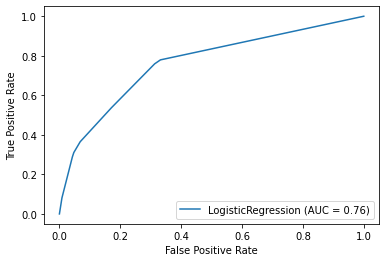

In [15]:
# Plot ROC Curve

plot_roc_curve(logreg_final,X_train_pipe_processed[lr_keep_lists[-1]],y_train)


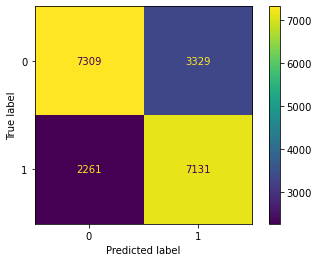

In [16]:
# Confusion Matrix of Final Logreg Model

plot_confusion_matrix(logreg_final,X_train_pipe_processed[lr_keep_lists[-1]],y_train)

### Final Model - Random Forest

## Conlclusion